In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(18,12)})

In [26]:
data_train = pd.read_excel("train_data.xlsx")
data_predict = pd.read_excel("predict_data.xlsx")
data_train.replace("–|-", np.nan, regex=True, inplace=True)
data_predict.replace("–|-", np.nan, regex=True, inplace=True)

Есть 2 набора данных: **train** и **predict**. В train есть информация и по водным показателям, и по донным (разделяются на **_h* и **_l* - отобраны на разных глубинах). В predict есть информация только по водным показателям. Задача -- предсказать донные по водным на датасете predict, обучив модель перед этим на train.

In [27]:
data_predict.head()

,pH,electricity,Ca,Mg,Na,K,HCO3,SO4,Cl,mineralisation,alkalinity,colour,NH4,NO3,N,PO4,P,Fe
0,7.01,36,4.26,0.74,1.36,0.24,14.2,3.77,0.97,25.5,232,28,14,3,117,0,2,43
1,6.66,29,1.87,0.77,1.71,0.35,7.32,3.84,1.08,16.9,120,77,NaN,7,252,3,8,82
2,7.08,31,3.21,0.77,1.63,0.36,13.2,2.90,0.90,22.9,216,30,10,16,159,1,5,33
3,6.09,20,1.45,0.66,1.22,0.31,11.2,2.00,1.00,12.2,184,31,19,3,199,0,7,71
4,5.23,10,0.47,0.18,0.59,0.15,NaN,2.30,0.80,4.5,NaN,3,26,1,166,1,6,15


In [4]:
data_train.head()

,pH,electricity,Ca,Mg,Na,K,HCO3,SO4,Cl,mineralisation,...,As_h,Hg_h,Cu_l,Ni_l,Zn_l,Co_l,Cd_l,Pb_l,As_l,Hg_l
0,6.87,33,2.13,0.82,3.32,0.64,16.0,1.2,1.3,25.4,...,2.01,0.077,8.1,7.0,98.0,4.3,0.14,0.79,1.68,0.014
1,7.59,135,3.95,0.36,21.30,5.50,38.6,18.3,2.6,90.6,...,NaN,NaN,94.0,9.8,54.0,4.6,0.80,4.20,NaN,NaN
2,6.44,13,0.40,0.20,1.64,0.34,2.9,1.4,1.3,8.1,...,NaN,0.150,12.0,16.0,125.0,11.6,0.14,3.62,NaN,0.051
3,6.82,35,2.23,0.87,3.14,0.71,15.6,1.3,1.7,25.5,...,5.73,0.119,8.7,5.6,58.0,6.7,0.12,1.90,4.78,0.058
4,5.75,14,0.45,0.36,1.42,0.23,1.2,1.3,1.7,6.5,...,3.02,0.078,48.0,28.0,108.0,9.7,0.26,0.99,1.68,0.054


In [63]:
data_train.shape

(92, 34)

In [64]:
data_predict.shape

(428, 18)

In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 34 columns):
pH                92 non-null float64
electricity       92 non-null int64
Ca                92 non-null float64
Mg                92 non-null float64
Na                92 non-null float64
K                 92 non-null float64
HCO3              92 non-null float64
SO4               92 non-null float64
Cl                92 non-null float64
mineralisation    92 non-null float64
alkalinity        92 non-null int64
colour            92 non-null int64
NH4               82 non-null object
NO3               92 non-null int64
N                 92 non-null int64
PO4               91 non-null object
P                 91 non-null object
Fe                92 non-null int64
Cu_h              92 non-null float64
Ni_h              92 non-null float64
Zn_h              92 non-null float64
Co_h              92 non-null float64
Cd_h              91 non-null object
Pb_h              92 non-null float64
A

In [6]:
data_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 18 columns):
pH                428 non-null float64
electricity       421 non-null object
Ca                428 non-null object
Mg                427 non-null object
Na                428 non-null float64
K                 428 non-null float64
HCO3              427 non-null object
SO4               428 non-null float64
Cl                428 non-null float64
mineralisation    428 non-null float64
alkalinity        427 non-null object
colour            420 non-null object
NH4               375 non-null object
NO3               421 non-null object
N                 405 non-null object
PO4               406 non-null object
P                 416 non-null object
Fe                423 non-null object
dtypes: float64(6), object(12)
memory usage: 40.2+ KB


Переведём всё в числа. Посчитаем пропущенные значения, запишем вместо них медиану.

In [28]:
data_train = data_train.apply(lambda x: x.astype(float))
data_train.isnull().sum()

pH                 0
electricity        0
Ca                 0
Mg                 0
Na                 0
K                  0
HCO3               0
SO4                0
Cl                 0
mineralisation     0
alkalinity         0
colour             0
NH4               10
NO3                0
N                  0
PO4                1
P                  1
Fe                 0
Cu_h               0
Ni_h               0
Zn_h               0
Co_h               0
Cd_h               1
Pb_h               0
As_h              36
Hg_h              30
Cu_l               0
Ni_l               0
Zn_l               0
Co_l               0
Cd_l               1
Pb_l               0
As_l              37
Hg_l              31
dtype: int64

In [29]:
data_predict["Ca"] = data_predict["Ca"].apply(lambda x: x.replace(',','.'))
data_predict = data_predict.apply(lambda x: x.astype(float))
data_predict.isnull().sum()

pH                 0
electricity        7
Ca                 0
Mg                 1
Na                 0
K                  0
HCO3               1
SO4                0
Cl                 0
mineralisation     0
alkalinity         1
colour             8
NH4               53
NO3                7
N                 23
PO4               22
P                 12
Fe                 5
dtype: int64

In [30]:
data_train = data_train.apply(lambda x: x.fillna(x.median()),axis=0)
data_predict = data_predict.apply(lambda x: x.fillna(x.median()),axis=0)

## plots

Картинки лучше смотерть в отдельном окне.

Совместные распределения параметров в датасете для прогнозирования (нет донных):

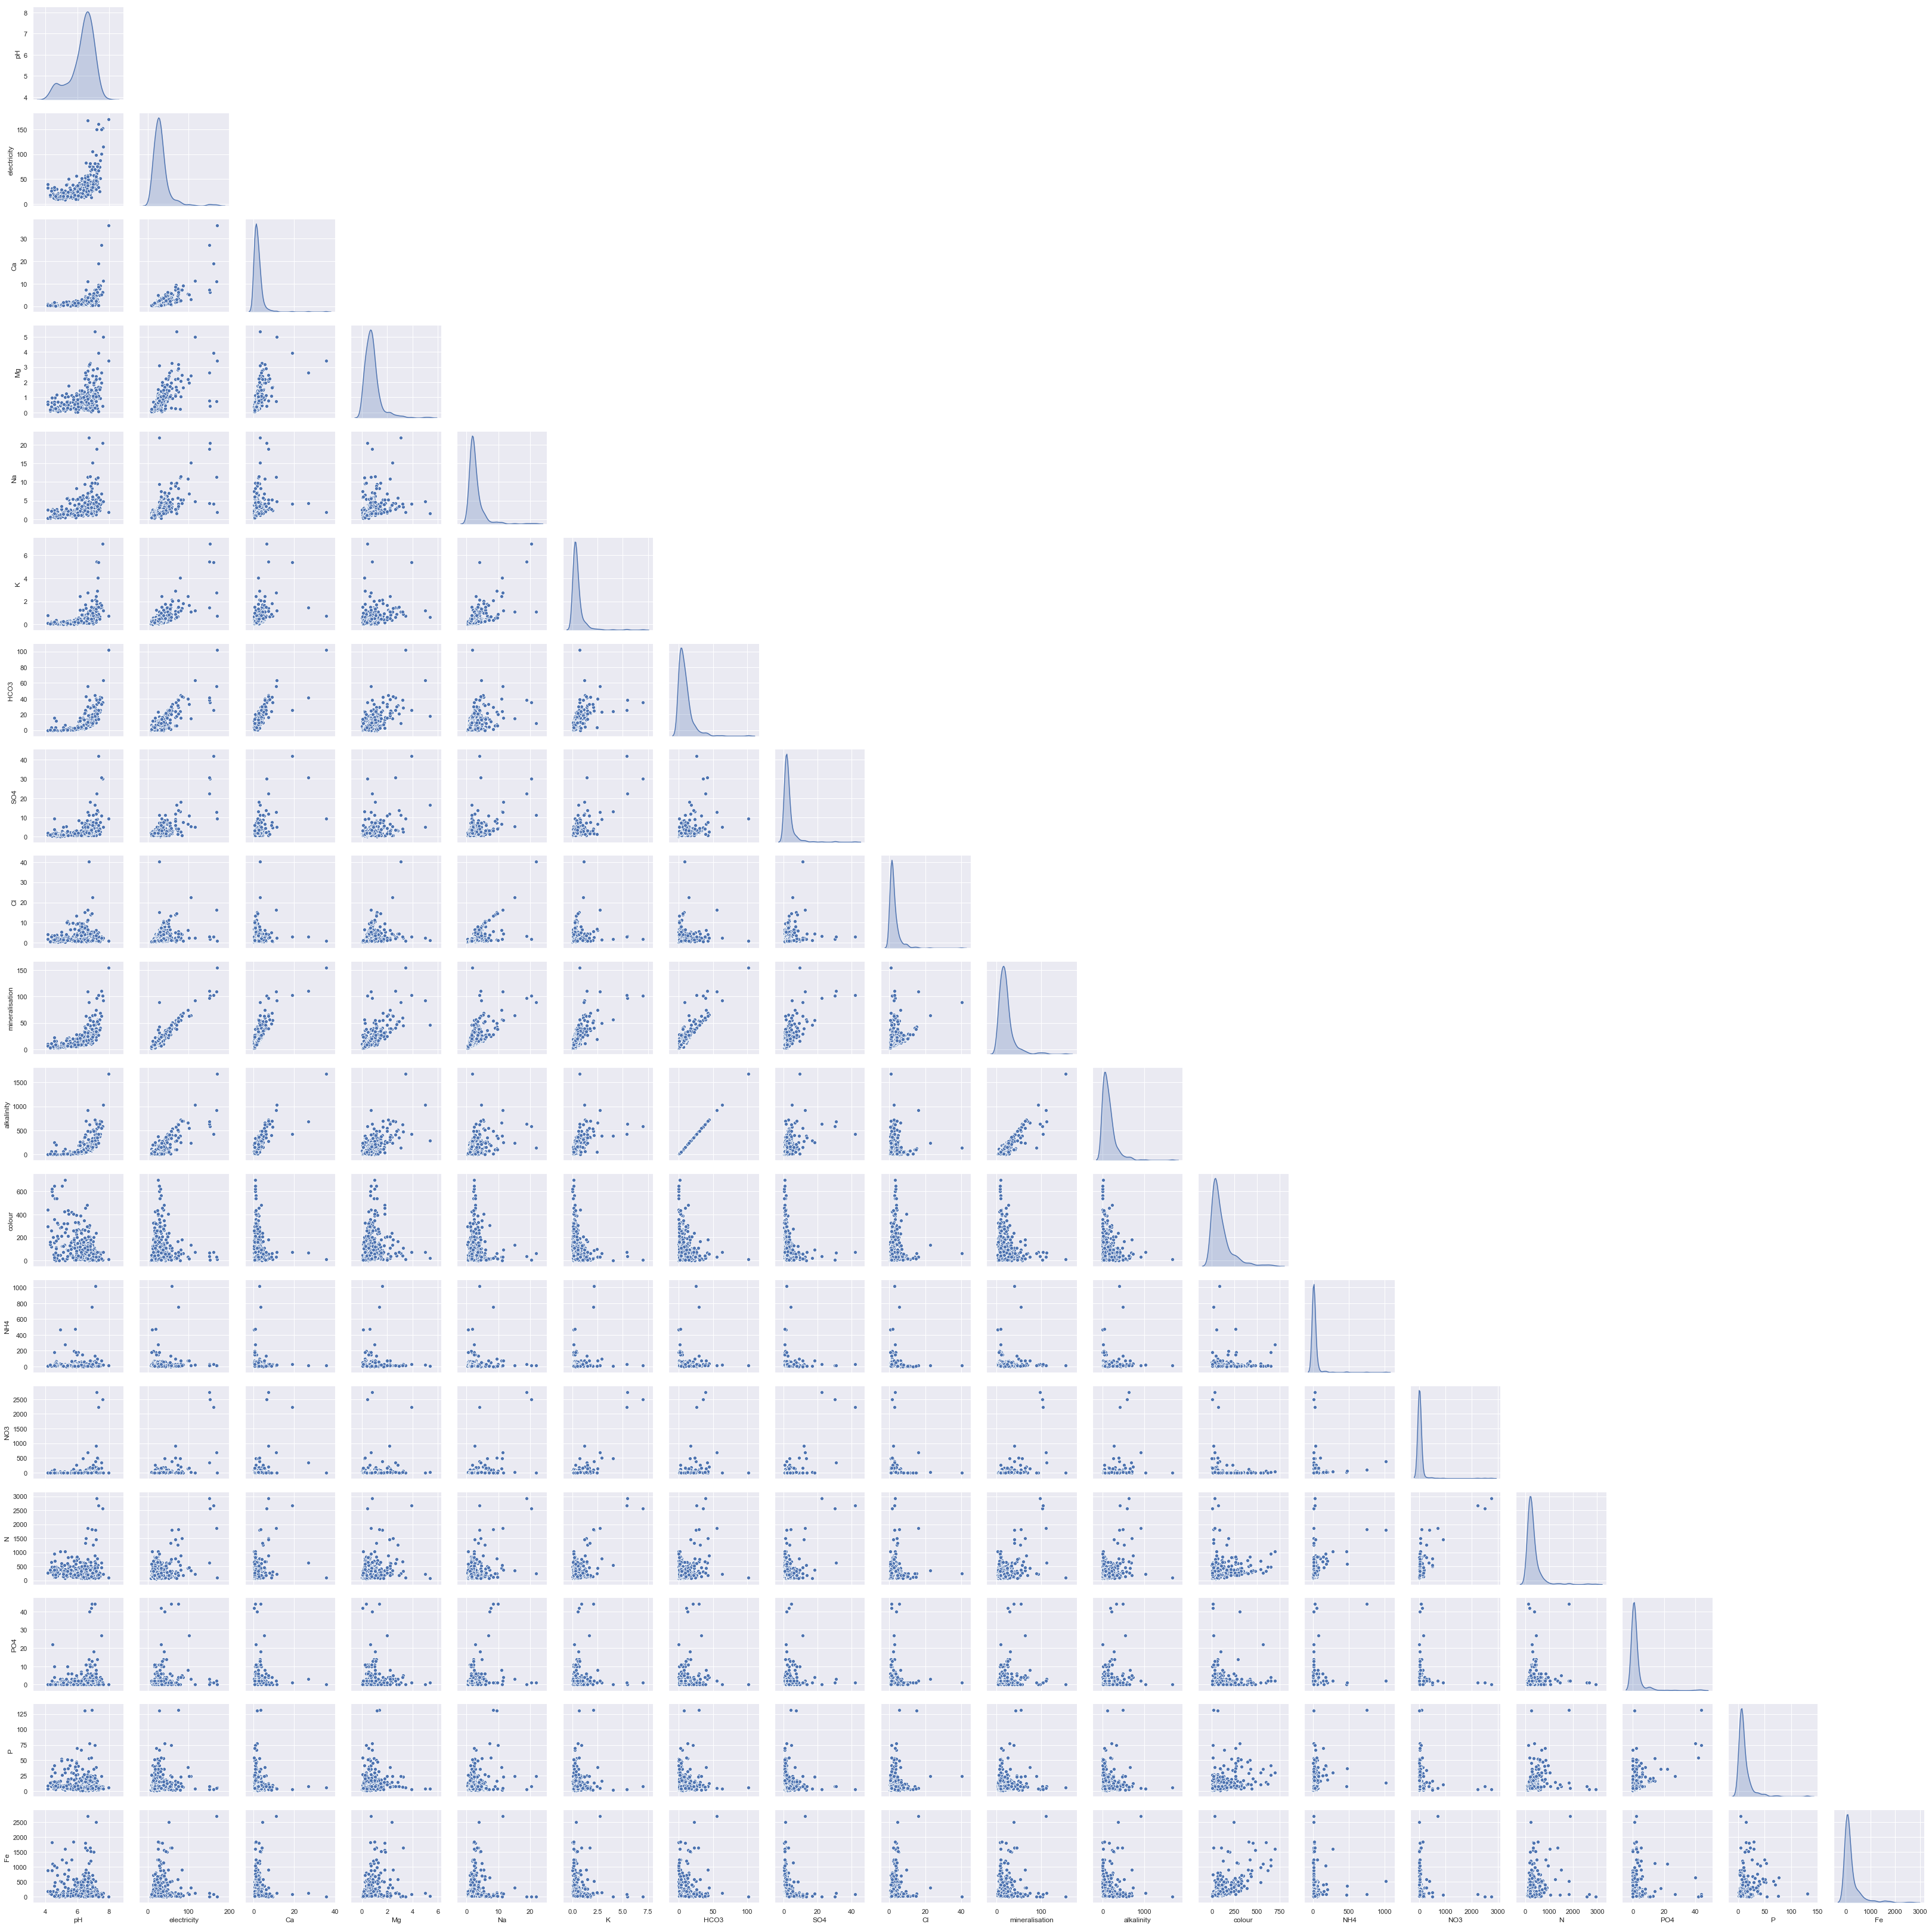

In [11]:
#Scatterplot Matrix
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
g = sns.pairplot(data_predict, diag_kind="kde")
g.map_upper(hide_current_axis);

В принципе на данном этапе нам не очень важна структура данных в датасете для прогнозирования. Важнее разобраться с train.

Совместные распределения параметров в датасете для обучения (донные vs водные):

<Figure size 360x360 with 0 Axes>

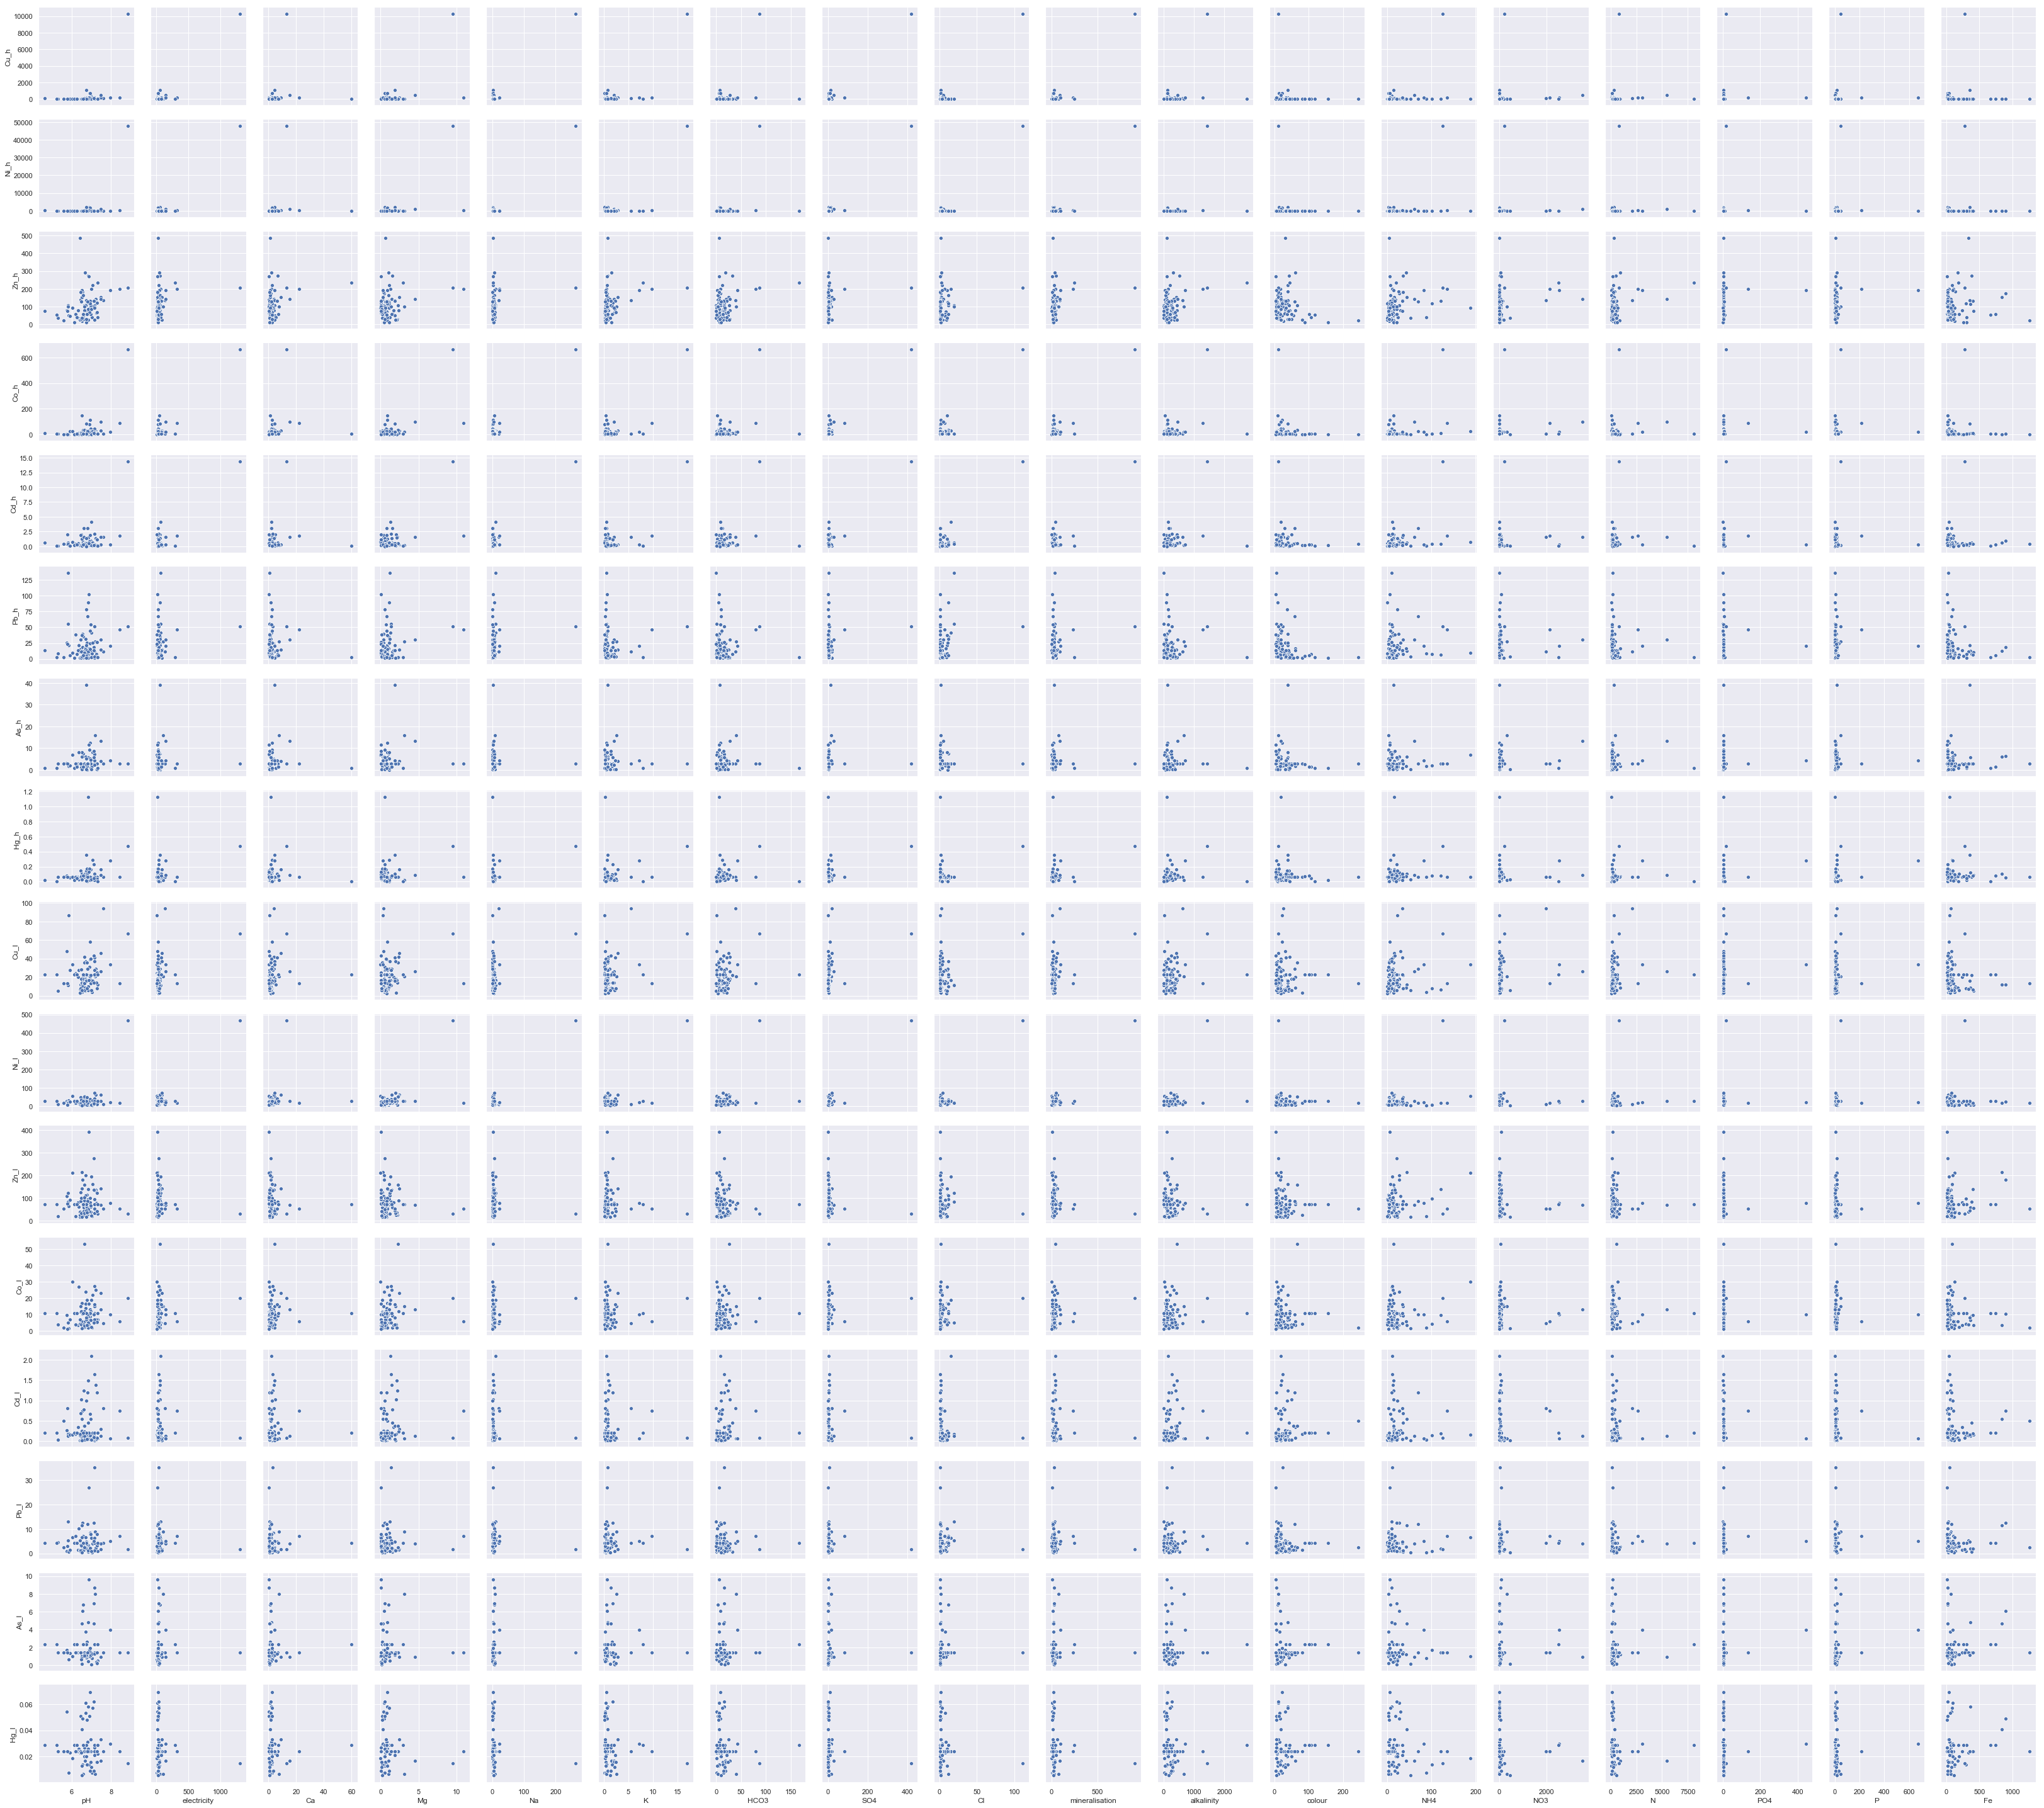

In [12]:
xs = ['pH', 'electricity', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'SO4', 'Cl', 'mineralisation', 'alkalinity', 'colour','NH4', 'NO3', 'N', 'PO4', 'P', 'Fe']
ys = ['Cu_h', 'Ni_h', 'Zn_h', 'Co_h', 'Cd_h', 'Pb_h', 'As_h', 'Hg_h', 'Cu_l', 'Ni_l', 'Zn_l', 'Co_l', 'Cd_l', 'Pb_l', 'As_l', 'Hg_l']

plt.figure(figsize = (5,5))
g = sns.pairplot(data_train,
                y_vars=ys,
                x_vars=xs);

Заметно много выбросов по ряду параметров.

Карта корреляции для учебного датасета (с выбросами).

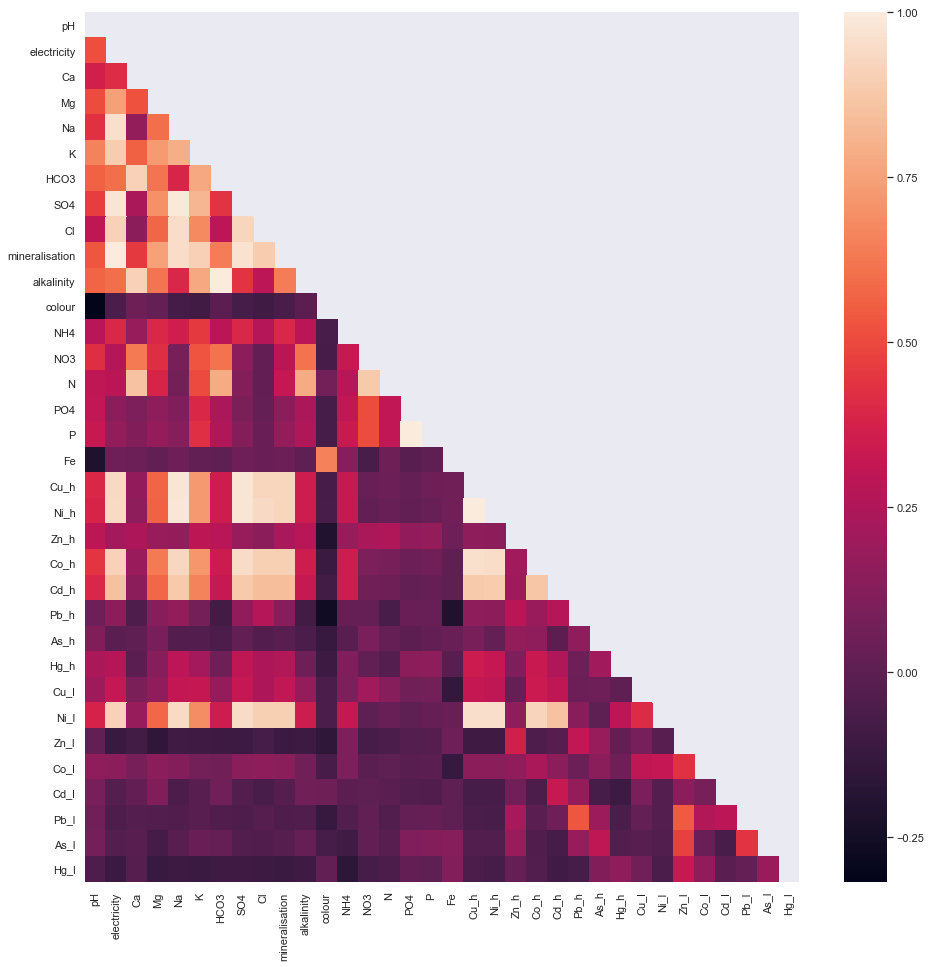

In [54]:
#Correlation heatmap
corr = data_train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (16,16))
sns.heatmap(corr, mask=mask,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

А-ха! Смотрим на квадрат: по Х - от начала и до Fe, по У - от Cu_h и до конца. Видим много светлых квадратиков (высокая корреляция). Глянем пример на выбор

Посмотрим на совместное распределение параметров Cu_h и Na с высокой корреляцией:

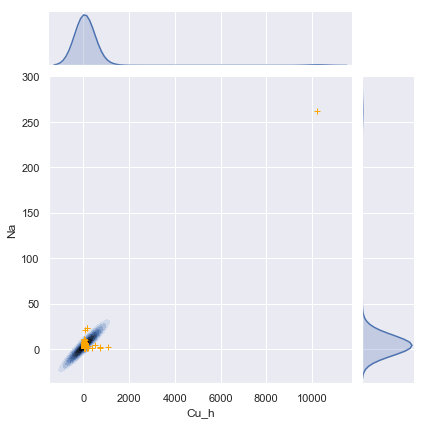

In [70]:
g = sns.jointplot(x="Cu_h", y="Na", data=data_train, kind="kde")
g.plot_joint(plt.scatter, c="orange", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0);

Выглядит уже не так хорошо, как казалось. Попробуем убрать выбросы.

In [62]:
#уберём выбросы (те, что дальше 4-х сигм)
data_train_no_outliers = data_train[(np.abs(stats.zscore(data_train)) < 4).all(axis=1)]
data_train_no_outliers.shape

(75, 34)

<Figure size 360x360 with 0 Axes>

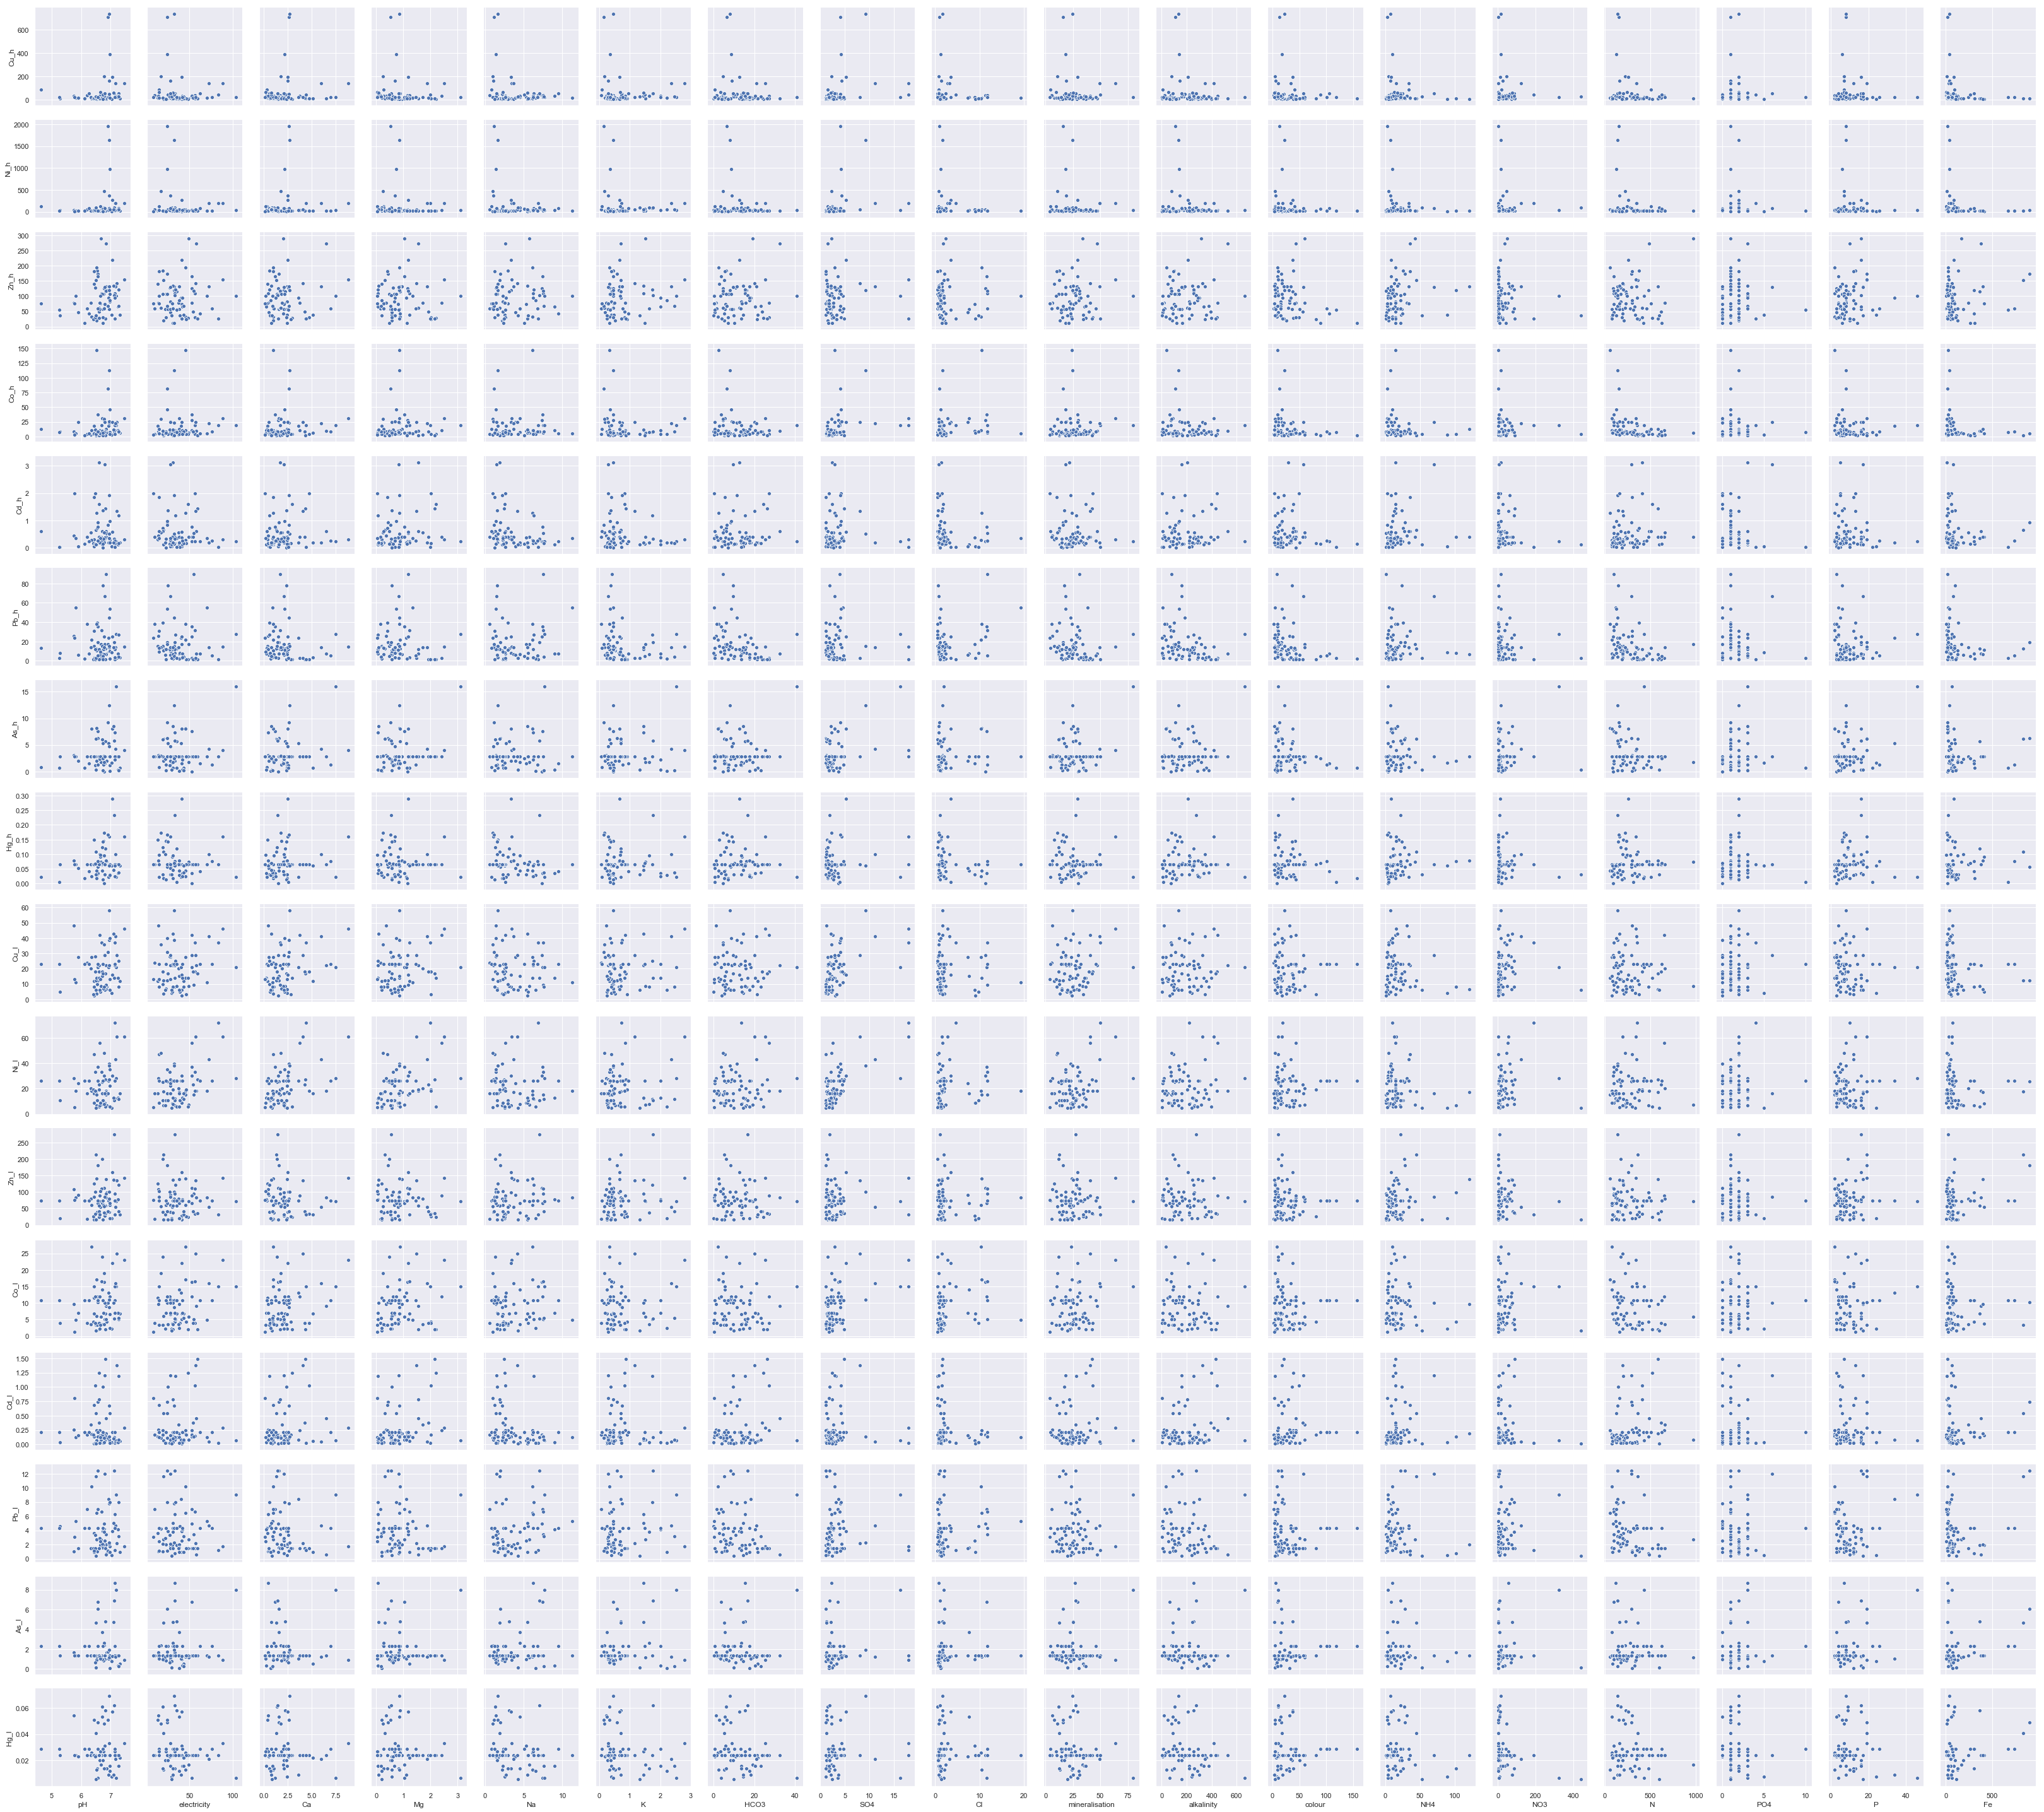

In [52]:
plt.figure(figsize = (5,5))
g = sns.pairplot(data_train_no_outliers,
                y_vars=ys,
                x_vars=xs);

Посмотрим на тот же пример Cu_h и Na, теперь без выбросов:

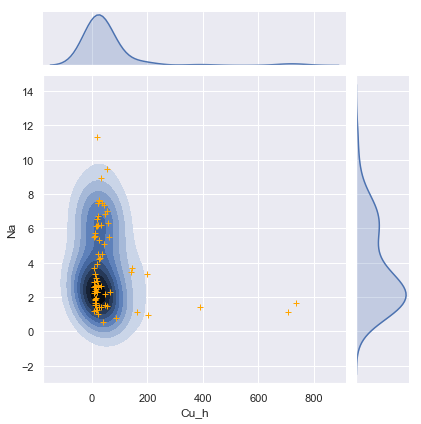

In [69]:
g = sns.jointplot(x="Cu_h", y="Na", data=data_train_no_outliers, kind="kde")
g.plot_joint(plt.scatter, c="orange", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0);

Всё погрустнело.. Посмотрим, что случилось с корреляцией:

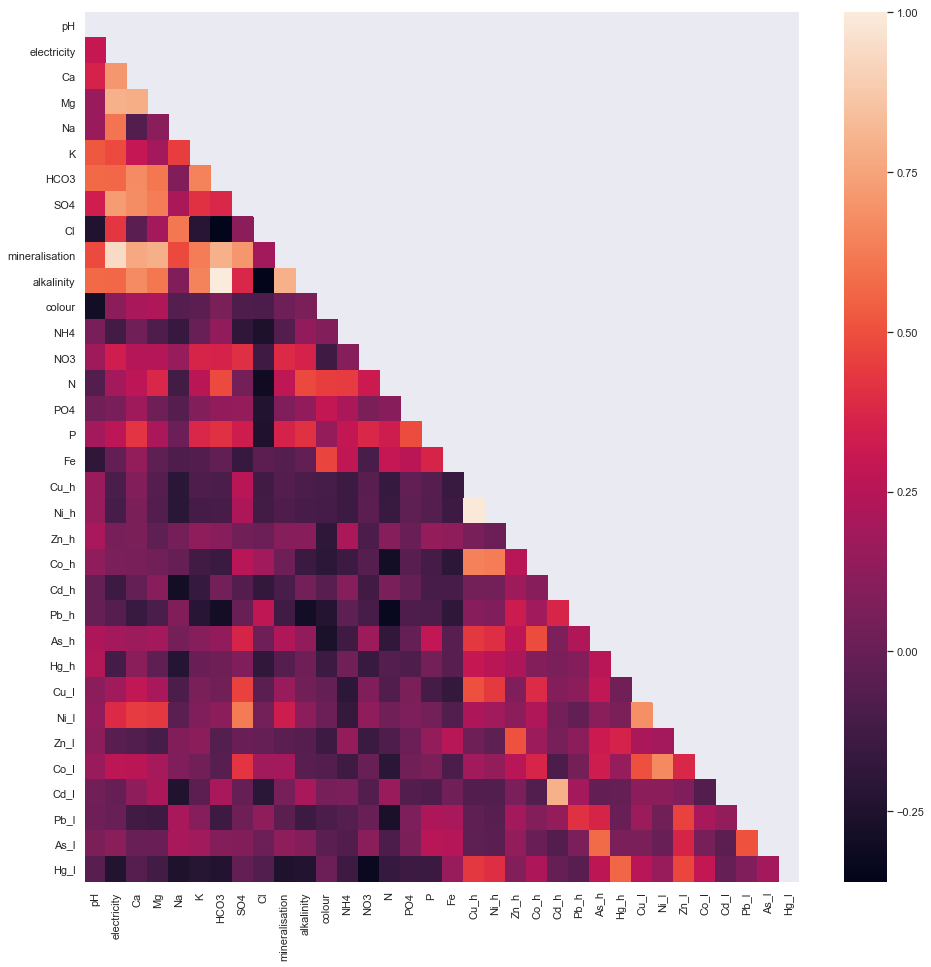

In [71]:
#Correlation heatmap
corr = data_train_no_outliers.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (16,16))
sns.heatmap(corr, mask=mask,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

На нашем квадратике стало темнее. Получается, что высокая корреляция была связана с выбросами (в одном наблюдении было несколько экстремальных значений). Так, но и здесь есть светлое пятно, посмотрим на него повнимательнее:

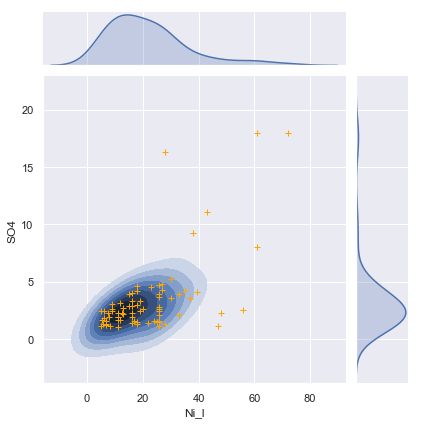

In [72]:
g = sns.jointplot(x="Ni_l", y="SO4", data=data_train_no_outliers, kind="kde")
g.plot_joint(plt.scatter, c="orange", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0);

Получаем **train** датасет из 75 наблюдений, с низкой корреляций между предикторами и прогнозируемыми параметрами.

## Попробуем модельки